# Broadway Sales Research Modeling

### Import and join datasets

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

weather = pd.read_pickle('data/processed/weather.pkl')
grosses = pd.read_pickle('data/processed/grosses.pkl')

In [305]:
weather = weather.rename(columns={"Week Ending":"Date"})
weather.head(2)

,Date,temperature_2m_mean,temperature_2m_min,temperature_2m_max,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,precipitation_hours,daylight_duration,sunshine_duration,snowfall_sum,showers_sum,rain_sum
0,1996-03-24 04:00:00,3.571250,-1.6725,10.427501,6.503645,-6.534769,-0.805065,0.000000,0.0,44429.293000,40204.098000,0.000000,0.0,0.0
1,1996-03-31 04:00:00,3.867679,-4.5225,14.877501,12.330812,-8.964521,-0.075191,111.899993,23.0,45082.879857,34754.791714,109.199993,0.0,2.7


In [306]:
grosses.head(2)

,ShowID,Date,Attendance,% Capacity,# Previews,# Perf.,Gross ($),Month,Year,Adjusted Gross
0,&-juliet-534962,2024-05-26,7540,0.92,0,8,877626,5,2024,897398.313035
1,&-juliet-534962,2024-06-02,6824,0.83,0,8,775476,6,2024,792946.943458


In [307]:
# Make Date columns same type
grosses['Date'] = grosses['Date'].dt.date
weather['Date'] = weather['Date'].dt.date

In [308]:
# Merge DFs
df = pd.merge(grosses, weather, on='Date', how='inner')

In [309]:
df.head(2)

,ShowID,Date,Attendance,% Capacity,# Previews,# Perf.,Gross ($),Month,Year,Adjusted Gross,...,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,precipitation_hours,daylight_duration,sunshine_duration,snowfall_sum,showers_sum,rain_sum
0,&-juliet-534962,2024-05-26,7540,0.92,0,8,877626,5,2024,897398.313035,...,30.266544,9.479221,20.403003,3.200000,6.0,52938.827571,45936.191143,0.0,0.0,3.200000
1,&-juliet-534962,2024-06-02,6824,0.83,0,8,775476,6,2024,792946.943458,...,27.329185,9.981629,18.406672,49.200001,26.0,53531.232857,42437.518571,0.0,0.0,49.200001


In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ShowID                     25991 non-null  object 
 1   Date                       25991 non-null  object 
 2   Attendance                 25991 non-null  int64  
 3   % Capacity                 25991 non-null  float64
 4   # Previews                 25991 non-null  int64  
 5   # Perf.                    25991 non-null  int64  
 6   Gross ($)                  25991 non-null  int64  
 7   Month                      25991 non-null  int32  
 8   Year                       25991 non-null  int32  
 9   Adjusted Gross             25991 non-null  float64
 10  temperature_2m_mean        25991 non-null  float64
 11  temperature_2m_min         25991 non-null  float64
 12  temperature_2m_max         25991 non-null  float64
 13  apparent_temperature_max   25991 non-null  flo

<ul>
    <li>
        Need to change Date column back to datetime format
    </li>
    <li>
        Need to engineer features to improve model performance:
        <ul><li>Create dummy variables for month</li>
            <li>Normalize/Standardize variables such as daylight duration or sunshine duration</li>
            <li>Remove redundant variables such as unadjusted gross to remove collinearity
    </li>

### Data Cleaning

In [313]:
# Checking for missing values
df.isnull().any()

ShowID                       False
Date                         False
Attendance                   False
% Capacity                   False
# Previews                   False
# Perf.                      False
Gross ($)                    False
Month                        False
Year                         False
Adjusted Gross               False
temperature_2m_mean          False
temperature_2m_min           False
temperature_2m_max           False
apparent_temperature_max     False
apparent_temperature_min     False
apparent_temperature_mean    False
precipitation_sum            False
precipitation_hours          False
daylight_duration            False
sunshine_duration            False
snowfall_sum                 False
showers_sum                  False
rain_sum                     False
dtype: bool

No missing values

In [315]:
# Converting date column back to datetime type
df['Date'] = pd.to_datetime(df['Date'])

In [316]:
# Account for duplicate rows
df = df.drop_duplicates()

In [317]:
# Drop irrelevant columns
df = df.drop(['Gross ($)', 'precipitation_sum', 'showers_sum'], axis = 1)

In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ShowID                     25991 non-null  object        
 1   Date                       25991 non-null  datetime64[ns]
 2   Attendance                 25991 non-null  int64         
 3   % Capacity                 25991 non-null  float64       
 4   # Previews                 25991 non-null  int64         
 5   # Perf.                    25991 non-null  int64         
 6   Month                      25991 non-null  int32         
 7   Year                       25991 non-null  int32         
 8   Adjusted Gross             25991 non-null  float64       
 9   temperature_2m_mean        25991 non-null  float64       
 10  temperature_2m_min         25991 non-null  float64       
 11  temperature_2m_max         25991 non-null  float64       
 12  appa

### Exploratory Data Analysis

<b>Univariate Analysis</b>

<Axes: xlabel='Adjusted Gross', ylabel='Count'>

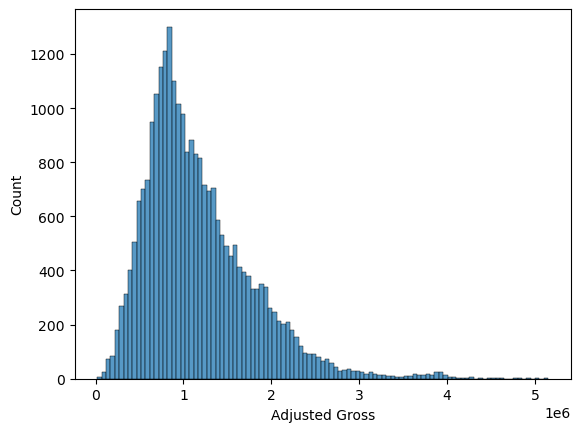

In [332]:
# Analyzing Grosses
sns.histplot(x=df['Adjusted Gross'])

<ul><li>Grosses are right skewed centered around a mean of roughly $900k</li>
<li>Most shows gross between 500k to 1.5M</li>

<Axes: xlabel='temperature_2m_min'>

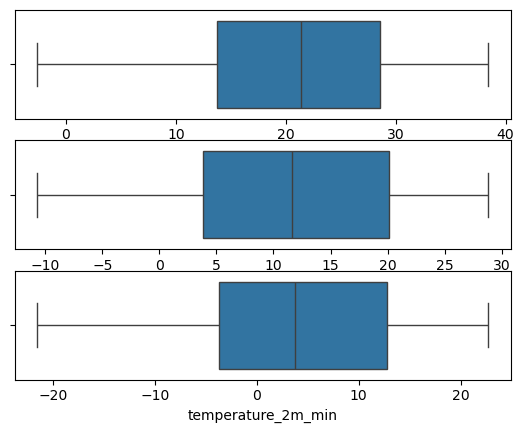

In [335]:
# Analyzing Temperature
fig, axs = plt.subplots(nrows=3)

sns.boxplot(x=df['temperature_2m_max'], ax=axs[0])
sns.boxplot(x=df['temperature_2m_mean'], ax=axs[1])
sns.boxplot(x=df['temperature_2m_min'], ax=axs[2])

<Axes: xlabel='Attendance', ylabel='Count'>

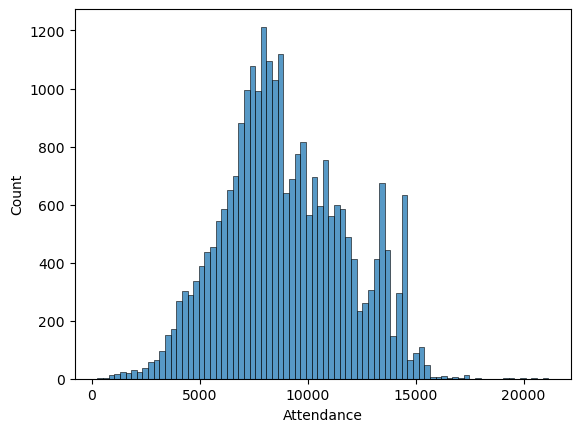

In [336]:
# Analyzing Attendance
sns.histplot(x=df['Attendance'])

Relatively normally distributed, peak around higher end because of popular shows

<b>Bivariate Analysis</b>

<Axes: >

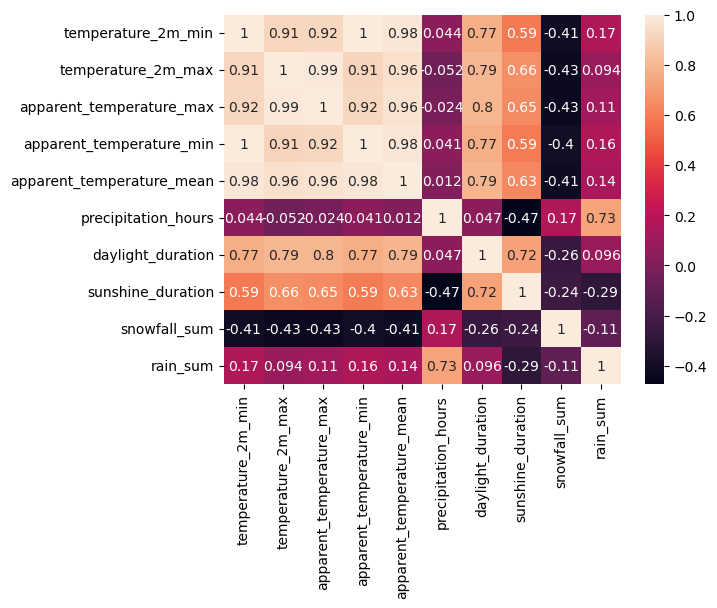

In [340]:
# Correlation Heatmap - check multicollinearity between weather regressor variables

sns.heatmap(df.iloc[:, 10:22].corr(), annot=True)

<u>Inferences:</u>
<ul>
    <li>Apparent and actual weather variable are highly correlated and could cause multicollinearity - should use one of these sets (actual weather) </li>
    <li>High correlation between sunshine and daylight duration variables, as well as daylight duration with other temperature variables (0.72-0.8). To address multicollinearity, can combine sunshine and daylight duration into a sunlight_ratio field, also making it more meaningful inference, which describes "what % of daylight was actually sunny?"</li>
    <li>High correlation between precipitation_hours and rain_sum, likely as there is a high probability that the longer rain occurs, the higher the sum of total precipitation. To address this multicollinearity, we can drop one of the fields - likely precipitation_hours, as we dont need to test for both intensity of rain and presence, and rain_sum is sufficient to describe a presence of rain with a moderate interpretation of intensity</li>
</ul>

<Axes: xlabel='Date'>

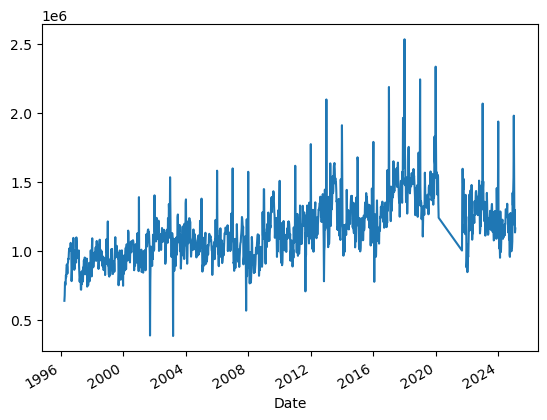

In [342]:
# Line plot: view yearly vs monthly seasonal trends in grosses
df.groupby("Date")["Adjusted Gross"].mean().plot()

Yearly peaks in adjusted grosses, agnostic of show type. Can examine a couple random years to see effect more clearly.

<Axes: xlabel='Month', ylabel='Adjusted Gross'>

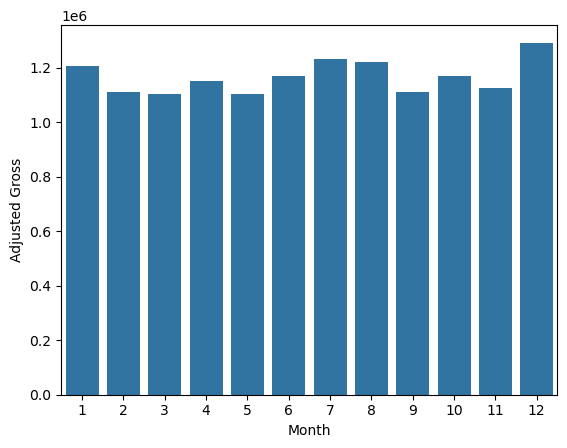

In [345]:
# Separating grosses by month to test the hypothesis of month-by-month seasonality in sales
sns.barplot(df.groupby("Month")["Adjusted Gross"].mean())

Dec/Jan as well as summer months are peaks - makes sense to make monthly dummies

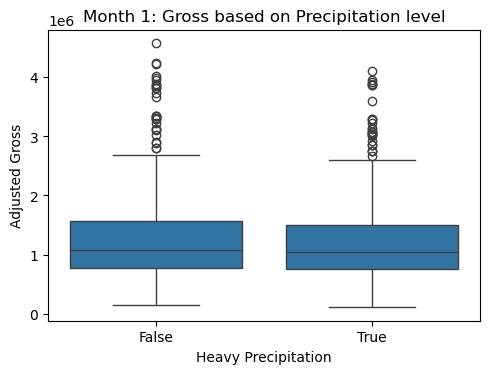

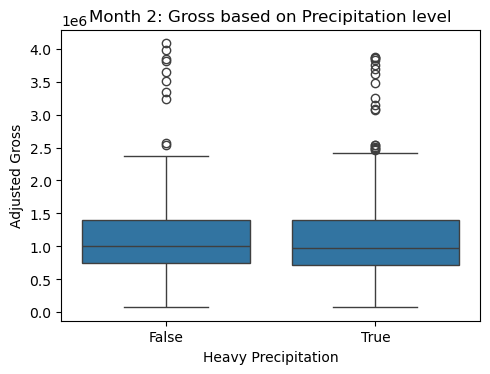

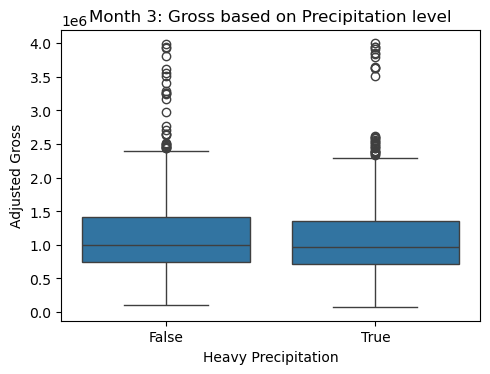

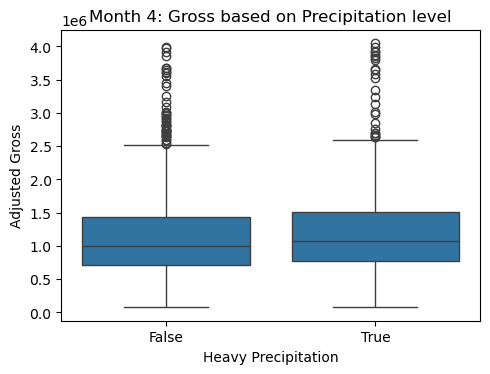

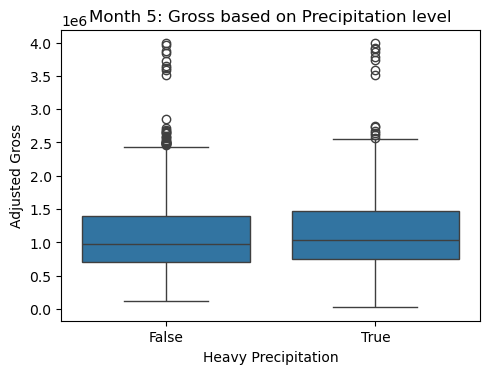

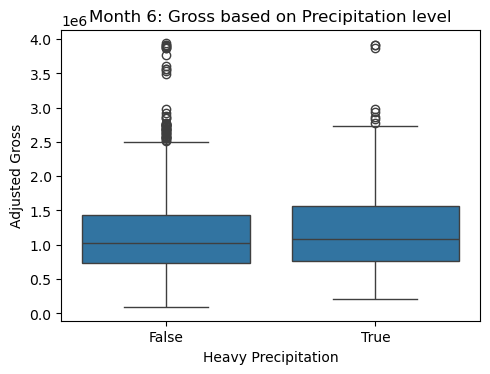

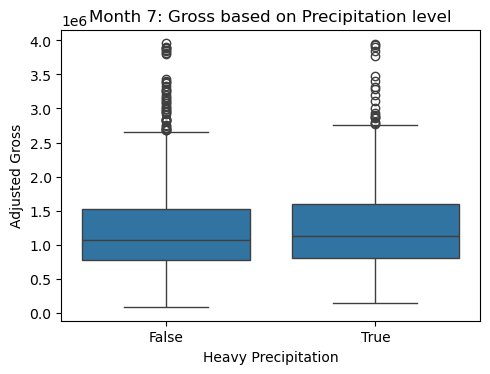

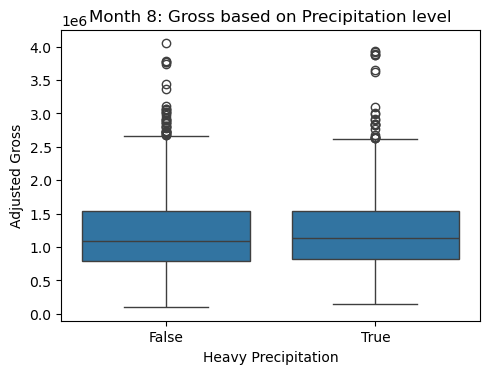

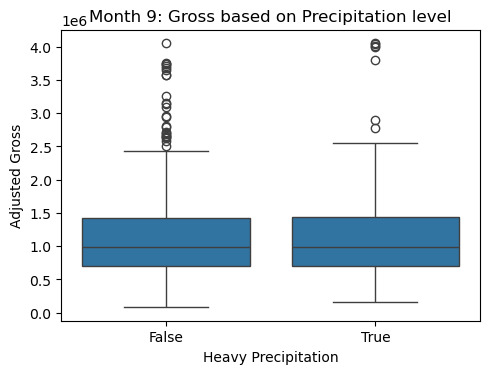

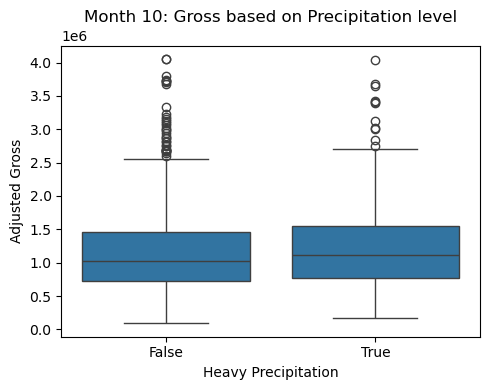

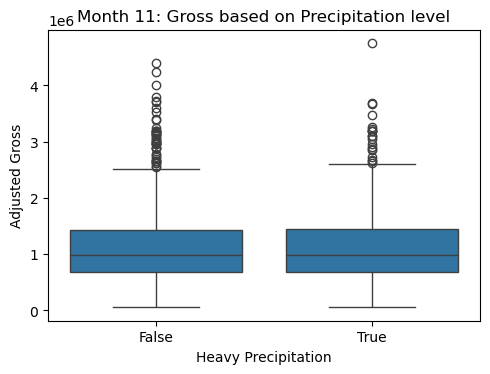

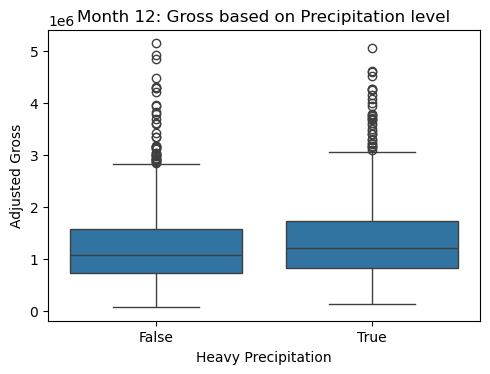

In [347]:
# Evaluate Grosses Distribution by heavy or not heavy precipitation
df['HeavyPrecipitation'] = (df['rain_sum'] + df['snowfall_sum']) > 30

for i in range(1,13):
    plt.figure(figsize=(5, 4))
    sns.boxplot(
    data=df[df['Month'] == i],
    x='HeavyPrecipitation',
    y='Adjusted Gross'
    )
    plt.title(f'Month {i}: Gross based on Precipitation level')
    plt.xlabel('Heavy Precipitation')
    plt.ylabel('Adjusted Gross')
    plt.tight_layout()
    plt.show()

No visible difference between grosses with heavy or light precipitation weeks

<Axes: xlabel='snowfall_sum', ylabel='Adjusted Gross'>

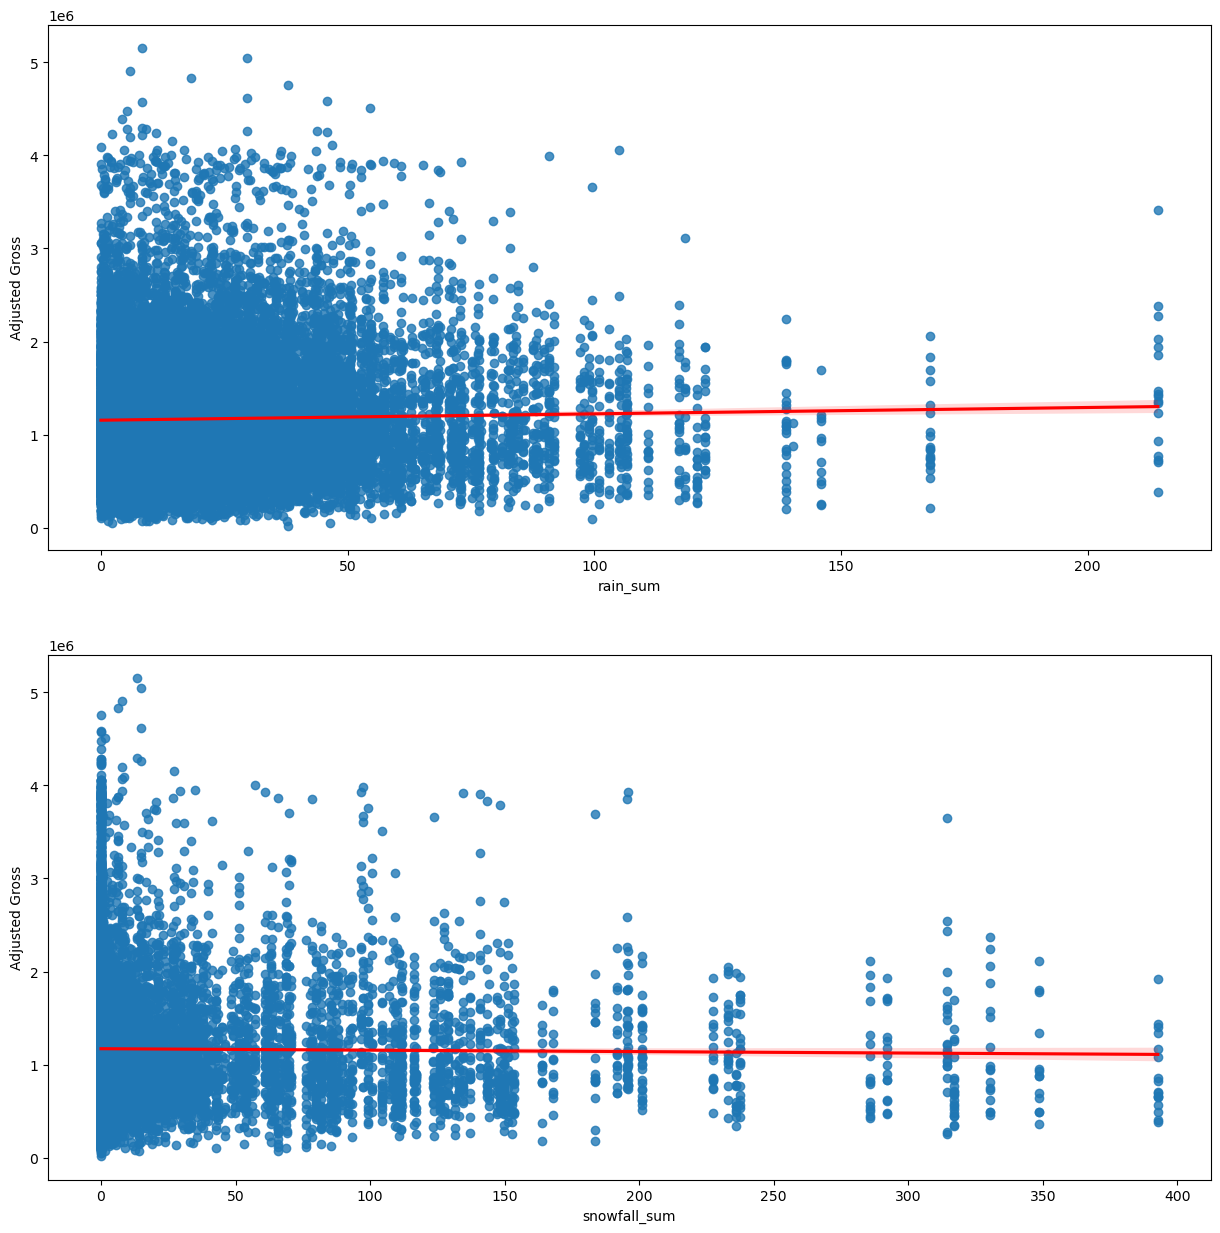

In [353]:
# Scatterplot Rain, Snow vs Adjusted Grosses

f, axes = plt.subplots(2,1, figsize=(15,15))
sns.regplot(data=df, x=df['rain_sum'], y=df['Adjusted Gross'], line_kws=dict(color="r"), ax=axes[0])
sns.regplot(data=df, x=df['snowfall_sum'], y=df['Adjusted Gross'], line_kws=dict(color="r"), ax=axes[1])

### Feature Engineering

In [355]:
# Revisit Columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ShowID                     25991 non-null  object        
 1   Date                       25991 non-null  datetime64[ns]
 2   Attendance                 25991 non-null  int64         
 3   % Capacity                 25991 non-null  float64       
 4   # Previews                 25991 non-null  int64         
 5   # Perf.                    25991 non-null  int64         
 6   Month                      25991 non-null  int32         
 7   Year                       25991 non-null  int32         
 8   Adjusted Gross             25991 non-null  float64       
 9   temperature_2m_mean        25991 non-null  float64       
 10  temperature_2m_min         25991 non-null  float64       
 11  temperature_2m_max         25991 non-null  float64       
 12  appa

In [356]:
# Create Sunlight Ratio column
df['Sunlight Ratio'] = df['sunshine_duration'] / df['daylight_duration']

In [357]:
# Log adjust target variable 
df['Adjusted Gross'] = np.log(df['Adjusted Gross'])

In [358]:
df = df.drop(columns=['temperature_2m_min', 'temperature_2m_max', 'apparent_temperature_min', 'apparent_temperature_max', 'precipitation_hours', 'daylight_duration', 'sunshine_duration'])

In [364]:
# Updated columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25991 entries, 0 to 25990
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ShowID                     25991 non-null  object        
 1   Date                       25991 non-null  datetime64[ns]
 2   Attendance                 25991 non-null  int64         
 3   % Capacity                 25991 non-null  float64       
 4   # Previews                 25991 non-null  int64         
 5   # Perf.                    25991 non-null  int64         
 6   Month                      25991 non-null  int32         
 7   Year                       25991 non-null  int32         
 8   Adjusted Gross             25991 non-null  float64       
 9   temperature_2m_mean        25991 non-null  float64       
 10  apparent_temperature_mean  25991 non-null  float64       
 11  snowfall_sum               25991 non-null  float64       
 12  rain

### Model Implementation (Two-Way Fixed Effects)

In [367]:
# import relevant stats package
from linearmodels.panel import PanelOLS

In [369]:
# set showid and date as indexes to sort data
df = df.set_index(['ShowID', 'Date'])

# regression model
model = PanelOLS.from_formula(
    'Q("Adjusted Gross") ~ temperature_2m_mean + apparent_temperature_mean + snowfall_sum + rain_sum + Q("Sunlight Ratio") + Q("# Perf.") + Q("# Previews") + C(Year) + C(Month) + EntityEffects',
    data=df
).fit()

In [371]:
print(model.summary)

                           PanelOLS Estimation Summary                           
Dep. Variable:     Q('Adjusted Gross')   R-squared:                        0.3059
Estimator:                    PanelOLS   R-squared (Between):             -0.5231
No. Observations:                25991   R-squared (Within):               0.3059
Date:                 Sat, Apr 19 2025   R-squared (Overall):             -0.0663
Time:                         13:44:54   Log-likelihood                    1450.9
Cov. Estimator:             Unadjusted                                           
                                         F-statistic:                      239.67
Entities:                          379   P-value                           0.0000
Avg Obs:                        68.578   Distribution:                F(47,25565)
Min Obs:                        2.0000                                           
Max Obs:                        1395.0   F-statistic (robust):           1.98e+06
                

In [373]:
# redoing regression model removing insignificant variables
model = PanelOLS.from_formula(
    'Q("Adjusted Gross") ~ temperature_2m_mean + snowfall_sum + rain_sum + Q("# Perf.") + Q("# Previews") + C(Year) + C(Month) + EntityEffects',
    data=df
).fit()

In [375]:
print(model.summary)

                           PanelOLS Estimation Summary                           
Dep. Variable:     Q('Adjusted Gross')   R-squared:                        0.3058
Estimator:                    PanelOLS   R-squared (Between):             -0.5230
No. Observations:                25991   R-squared (Within):               0.3058
Date:                 Sat, Apr 19 2025   R-squared (Overall):             -0.0663
Time:                         13:46:07   Log-likelihood                    1450.4
Cov. Estimator:             Unadjusted                                           
                                         F-statistic:                      250.32
Entities:                          379   P-value                           0.0000
Avg Obs:                        68.578   Distribution:                F(45,25567)
Min Obs:                        2.0000                                           
Max Obs:                        1395.0   F-statistic (robust):          2.068e+06
                

---
### Model Overview
| Metric               | Value     | Meaning |
|----------------------|-----------|---------|
| R-squared (Within)   | **0.3058**| Explains ~30.6% of **within-show revenue variation** |
| F-statistic          | **250.32**| Model is **highly significant** (p < 0.001) |
| Fixed Effects        | yes        | **ShowID (Entity)**, `Year`, and `Month` |

### Key Variable Insights

| Variable              | Coefficient | Significance | Interpretation |
|-----------------------|-------------|--------------|----------------|
| `# of Perf.`             | +0.2000     | yes        | +0.2 per added performance | 
| `# of Previews`          | +0.1977     | yes       | +0.198  per added preview |
| `temperature_2m_mean` | +0.0023     | yes          | Small revenue increase with warmer weather |
| `snowfall_sum`        | -0.0002     | yes           | Snow **negatively** affects revenue |
| `rain_sum`            | +0.0001     | no (p ≈ 0.08)| Weak/noisy and unreliable relationship |

**Takeaway**: Show volume (`# Perf.`, `# Previews`) drives revenue the most. Weather effects are present but small.

### Time Fixed Effects

**Year (`C(Year)`):**
- Peak revenue: **1996–2000 (~12.8)**
- Gradual decline post-2020 (~11.95) → likely due to **COVID impact**

**Month (`C(Month)`):**
| Month      | Effect | Insight                           |
|------------|--------|------------------------------------|
| December   | +0.051 | Holiday boost                   |
| September  | -0.158 | Back-to-school slump            |
| Spring/Summer (May–June) | ~-0.08 | Lower seasonal attendance        |

---

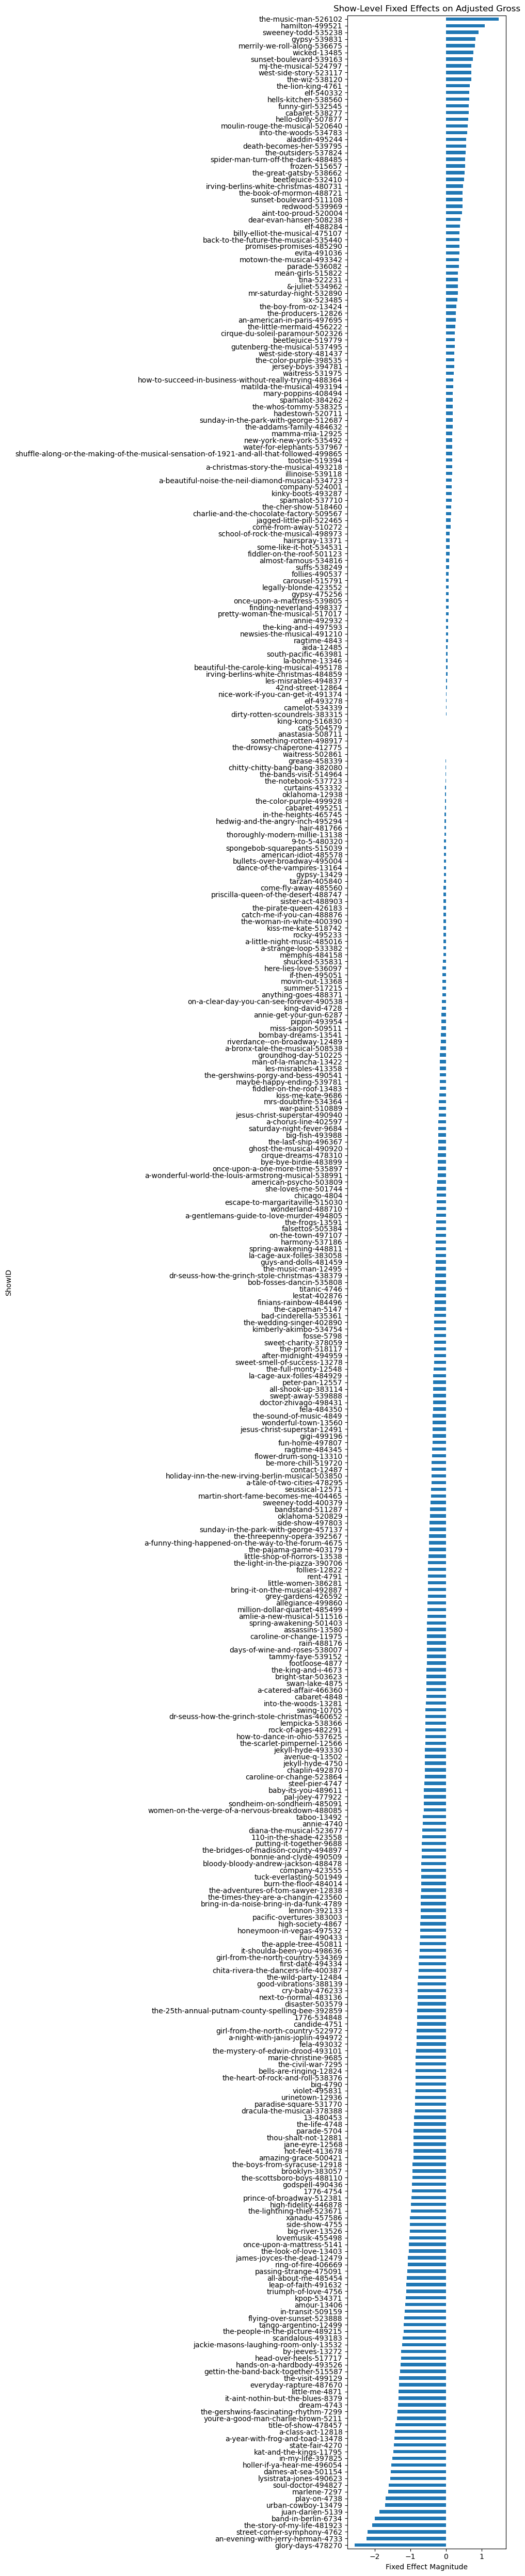

In [400]:
# unpack show effects - shows how popular shows 
avg_show_effects = model.estimated_effects.groupby(level='ShowID').mean().squeeze()

avg_show_effects.sort_values().plot(kind='barh', figsize=(10, 50))
plt.title("Show-Level Fixed Effects on Adjusted Gross")
plt.xlabel("Fixed Effect Magnitude")
plt.ylabel("ShowID")
plt.tight_layout()

#### Key Insights:

<ul>
    <li><b><u>Show Strength (Entity Fixed Effect)</u></b>: As hypothesized, after accounting for other variables (such as weather, time effects and number of previews etc.), there are shows that inherently perform better or worse on average</li>
    <li>Popular shows such as Wicked, Lion King or Aladdin tend to do well despite poorer weather conditions due to many factors, such as strong brand, loyal fanbase or better casting.</li>
    <li>On the flip side, shows such as Glory days, Band in Berlin or Soul Doctor tend to worse, despite favourable regressor variables - for the same reasons unobserved in the model </li>
</ul>

### Check for Model Reliability

In [381]:
# Extract estimated fixed effects and their standard errors
fe_df = model.estimated_effects.unstack().T  # shape: (ShowID x Date) → transpose
fe_means = fe_df.mean(axis=1)  # average fixed effect per ShowID
fe_stds = fe_df.std(axis=1)    # standard deviation of fixed effect estimates

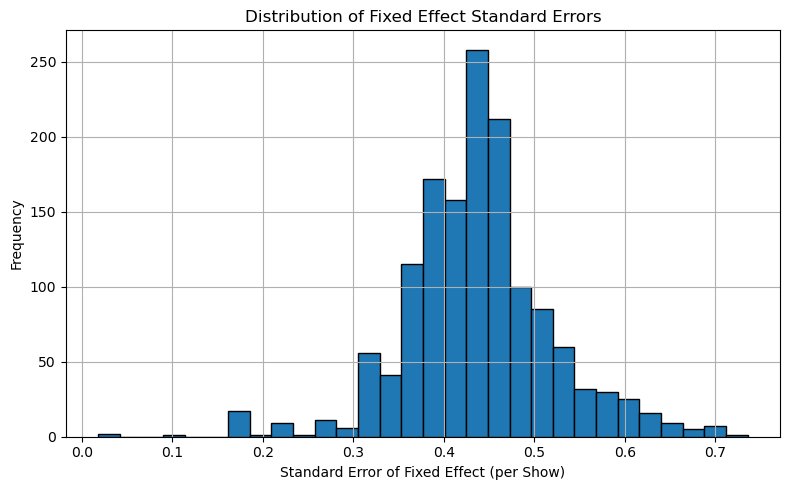

In [383]:
# Plot histogram of standard errors
fe_stds.hist(bins=30, edgecolor='black', figsize=(8, 5))
plt.title("Distribution of Fixed Effect Standard Errors")
plt.xlabel("Standard Error of Fixed Effect (per Show)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Standard distribution of errors is relatively normal - regression analysis is more or less reliable as the variation is random

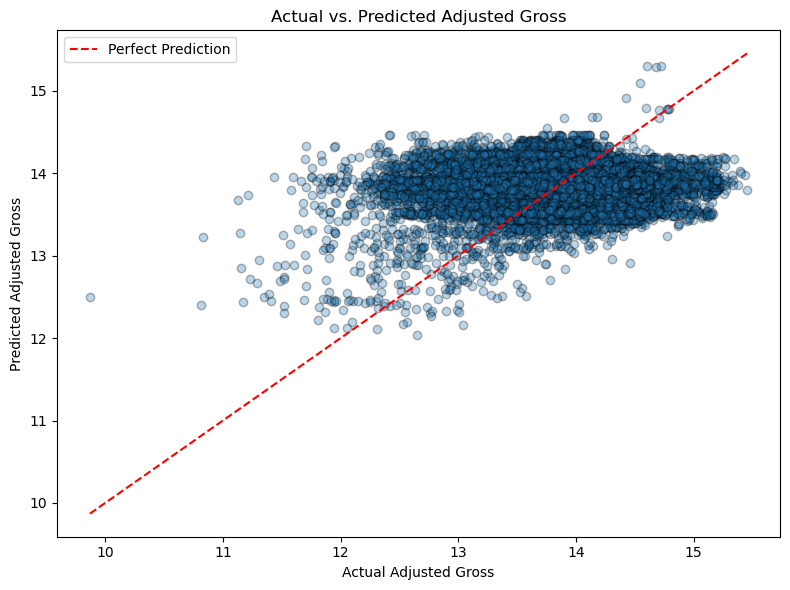

In [395]:
# Plotting Actual vs predicted to assess model fit
predicted = model.predict().fitted_values
actual = model.model.dependent.values2d

plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.3, edgecolors='k')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Adjusted Gross")
plt.ylabel("Predicted Adjusted Gross")
plt.title("Actual vs. Predicted Adjusted Gross")
plt.legend()
plt.tight_layout()
plt.show()